<a href="https://colab.research.google.com/github/drshahizan/Python_EDA/blob/main/assignment/ass3/bdm/TheBoys/ass3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TheBoys - Assignment 3
1. Pang Chern Hong | MCS231006
2. Nian Cong    | MCS231007
3. Wu Jiaming    | MCS221033
4. Liu Kaiyuan   | MCS231020

In [ ]:
pip install geotext

In [ ]:
pip install -U kaleido

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tianhwu/brooklynhomes2003to2017
! unzip brooklynhomes2003to2017.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
brooklynhomes2003to2017.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brooklynhomes2003to2017.zip
replace brooklyn_sales.rds? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geotext
import collections
import string, sys, os, re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from functools import reduce
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
warnings.filterwarnings('ignore')

## Helper functions and classes

In [ ]:
class DfOverview:
    """
        Give an overview for a given data frame,
        like null persentage for each columns,
        unique value percentage for each columns and more
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def missing_value(self) -> None:
        nullSum = self.df.isna().sum()
        return [col for col in nullSum]

    def percentage(self, list):
        return [str(round(((value / self.df.shape[0]) * 100), 2)) + '%' for value in list]

    def getOverview(self) -> None:

        _columns = [column for column in self.df]
        _count = self.df.count().values
        _unique = [self.df[column].value_counts().shape[0] for column in self.df]
        _missing_values = self.missing_value()

        columns = [
            'Column',
            'count',
            'missing_value_count',
            'Missing_value_percentage',
            'unique_value_count',
            'unique_value_percentage',
            'dtype']
        data = zip(
            _columns,
            _count,
            _missing_values,
            self.percentage(_missing_values),
            _unique,
            self.percentage(_unique),
            self.df.dtypes
        )
        new_df = pd.DataFrame(data=data, columns=columns)
        return new_df

In [ ]:
def show_cols_mixed_dtypes(df):
    mixed_dtypes = {'Column': [], 'Data type': []}
    for col in df.columns:
        dtype = pd.api.types.infer_dtype(df[col])
        if dtype.startswith("mixed"):
            mixed_dtypes['Column'].append(col)
            mixed_dtypes['Data type'].append(dtype)
    if len(mixed_dtypes['Column']) == 0:
        print('None of the columns contain mixed types.')
    else:
        print(pd.DataFrame(mixed_dtypes))

In [ ]:
def percent_missing_values(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

In [ ]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending and remove columns with no missing values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,0] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    if mis_val_table_ren_columns.shape[0] == 0:
        return

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [ ]:
def convert_to_string(df, columns):
    for col in columns:
        df[col] = df[col].astype("string")

In [ ]:
def drop_duplicates(df):
    old = df.shape[0]
    df.drop_duplicates(inplace=True)
    new = df.shape[0]
    count = old - new
    if (count == 0):
        print("No duplicate rows were found.")
    else:
        print(f"{count} duplicate rows were found and removed.")

def plot_dist(df:pd.DataFrame, column:str, color:str='cornflowerblue')->None:
    sns.displot(data=df, x=column, color=color,  kde=False, height=6, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plotly_plot_bar(df, x, y, title=None, width=800, color=['cornflowerblue']):
    if title == None:
        title=f'Distribution of {x}'
    fig = px.bar(df, x=x, y=y, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

def plotly_plot_pie(df, column, title=None, width=800, limit=None):
    a = pd.DataFrame({'count': df.groupby([column]).size()}).reset_index()
    a = a.sort_values("count", ascending=False)
    if limit:
        a.loc[a['count'] < limit, column] = f'Other {column}s'
    if title == None:
        title=f'Distribution of {column}'
    fig = px.pie(a, values='count', names=column, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

## Data Reading

In [ ]:
# reading the companies_sorted csv file
df = pd.read_csv("/content/brooklyn_sales_map.csv")
df

,Unnamed: 0,borough,neighborhood,building_class_category,tax_class,block,lot,easement,building_class,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_sqft,gross_sqft,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,year_of_sale,Borough,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCent,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area
0,1,3,DOWNTOWN-METROTECH,28 COMMERCIAL CONDOS,4,140,1001,NaN,R5,330 JAY STREET,COURT,11201,0,1,1,0.0,0.0,2002,4,R5,499401179.0,2008-04-23,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3,DOWNTOWN-FULTON FERRY,29 COMMERCIAL GARAGES,4,54,1,NaN,G7,85 JAY STREET,NaN,11201,0,0,0,134988.0,0.0,0,4,G7,345000000.0,2016-12-20,2016,BK,302.0,21.00,3017.0,13.0,33.0,11201.0,L118,84.0,36.0,1000.0,3.0,2.0,1B,87 JAY STREET,M1-2/R8,NaN,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,NaN,N,G7,10.0,0.0,P,85 JAY STREET BROOKLY,134988.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,490.50,275.33,0.0,0.00,NaN,0.0,N,5.0,5.0,1571850.0,1571850.0,1571850.0,1571850.0,0.0,0.0,0.0,NaN,NaN,0.00,7.20,2.0,6.5,3.0,3.000540e+09,0.0,21.0,988208.0,195011.0,12d,NaN,302 016,30101.0,NaN,3.000540e+09,12/06/2002,1.0,NaN,NaN,17V1.1,0.0,1559.889144,140131.577176
2,3,3,BROOKLYN HEIGHTS,21 OFFICE BUILDINGS,4,204,1,NaN,O6,29 COLUMBIA HEIGHTS,NaN,11201,0,0,0,32000.0,304650.0,1924,4,O6,340000000.0,2016-08-03,2016,BK,302.0,1.00,1003.0,13.0,33.0,11201.0,E205,84.0,38.0,2300.0,3.0,2.0,1A,29 COLUMBIA HEIGHTS,M2-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,O6,5.0,0.0,NaN,25-30 COLUMBIA HEIGHT,32000.0,304650.0,304650.0,0.0,264750.0,0.0,0.0,0.0,0.0,39900.0,2.0,1.0,13.0,0.0,0.0,92.42,335.92,335.0,92.00,NaN,0.0,Y,3.0,5.0,1548000.0,25463250.0,0.0,0.0,1924.0,1980.0,0.0,NaN,NaN,9.52,0.00,2.0,0.0,3.0,3.002040e+09,0.0,1.0,985952.0,195007.0,12d,NaN,302 004,30106.0,NaN,0.000000e+00,NaN,1.0,NaN,NaN,17V1.1,0.0,890.718521,34656.447240
3,4,3,MILL BASIN,22 STORE BUILDINGS,4,8470,55,NaN,K6,5120 AVENUE U,NaN,11234,0,123,123,905000.0,2548000.0,1970,4,K6,276947000.0,2012-11-28,2012,BK,318.0,698.00,2005.0,22.0,46.0,11234.0,E323,63.0,35.0,8822.0,3.0,18.0,4E,5120 AVENUE U,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,K6,5.0,1.0,NaN,BROOKLYN KINGS PLAZA,905000.0,2548000.0,2548000.0,0.0,0.0,1263000.0,1285000.0,0.0,0.0,0.0,2.0,4.0,2.0,0.0,123.0,930.00,859.00,0.0,0.00,NaN,0.0,Y,3.0,5.0,36532350.0,149792400.0,0.0,0.0,1970.0,0.0,0.0,NaN,NaN,2.82,0.00,2.0,0.0,3.0,3.084700e+09,0.0,698.0,1006597.0,161424.0,23b,NaN,319 077,32502.0,NaN,0.000000e+00,NaN,1.0,1.0,1.0,17V1.1,0.0,3729.786857,797554.847834
4,5,3,BROOKLYN HEIGHTS,26 OTHER HOTELS,4,230,1,NaN,H8,21 CLARK STREET,NaN,11201,0,1,1,20267.0,356000.0,1927,4,H8,202500000.0,2017-10-31,2017,BK,302.0,3.01,2000.0,13.0,33.0,11201.0,E205,84.0,38.0,2300.0,3.0,2.0,1A,79 WILLOW STREET,R6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LH-1,N,H8,8.0,0.0,X,WATCHTOWER C/O REAL P,20267.0,356000.0,30000.0,0.0,30000.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,15.0,0.0,1.0,202.00,100.33,202.0,100.33,NaN,0.0,N,3.0,2.0,2250000.0,27166050.0,225

## General Statistics

In [ ]:
# number of elements(cells) in the df
df.size

43388013

In [ ]:
pd.options.display.max_columns = None
df.sample()

,Unnamed: 0,borough,neighborhood,building_class_category,tax_class,block,lot,easement,building_class,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_sqft,gross_sqft,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,year_of_sale,Borough,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCent,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area
353575,353576,3,PARK SLOPE,03 THREE FAMILY HOMES,NaN,934,30,NaN,NaN,118 ST MARKS PLACE,NaN,11217,0,0,0,0.0,0.0,0,1,C0,1200000.0,2005-02-17,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# rows and columns in the df
df.shape

(390883, 111)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390883 entries, 0 to 390882
Columns: 111 entries, Unnamed: 0 to SHAPE_Area
dtypes: float64(64), int64(11), object(36)
memory usage: 331.0+ MB


In [ ]:
df_overview = DfOverview(df)
df_overview.getOverview()

,Column,count,missing_value_count,Missing_value_percentage,unique_value_count,unique_value_percentage,dtype
0,Unnamed: 0,390883,0,0.0%,390883,100.0%,int64
1,borough,390883,0,0.0%,1,0.0%,int64
2,neighborhood,390883,0,0.0%,64,0.02%,object
3,building_class_category,390800,83,0.02%,88,0.02%,object
4,tax_class,383949,6934,1.77%,10,0.0%,object
...,...,...,...,...,...,...,...
106,PFIRM15_FL,27773,363110,92.89%,1,0.0%,float64
107,Version,303728,87155,22.3%,1,0.0%,object
108,MAPPLUTO_F,303728,87155,22.3%,4,0.0%,float64
109,SHAPE_Leng,303728,87155,22.3%,152407,38.99%,float64


Here we can see detailed informations of the columns including the amount missing and unique values.

## Dropping unnecessary Columns

This data set has a full 111 columns, a large portion of which are useless.
A big simplification can be done by removing duplicate columns. Also there are some coumns refering various map ID or file numbers which supposedly have no impact on any of the predictions made.

**The following are the parts we retain and their meanings:**

Address: The street address of the property.

Apartment Number: Self-explanatory. List the apartment number of the property.

Zip Code: Postal code for the property. Brooklyn has 52 different zip codes, and zip codes have a strong correlation with property value.

Land Sqft: The amount of usable square footage for the property.

Year Built: The year that the property was built.

Building Class At Sale: Building classifications in NYC denote the general condition of a commercial property and indicate the quality of its location and amenities. The building class can significantly impact the property's price, so it will not be dropped.

Sales Price: The final price of the property at the time of sale.

Sale Date: The full date of the property at the time of sale.

School District: The community school district designated for this property.

Prox Code: The proximity code for the property details the attachedness of this property to other properties. It originates from New York City's Department of Planning open data. The values are as follows: 0: Not available, 1: Detached, 2: Semi-attached, 3: Attached.

Lot Area: Lot area represents the size of the piece of land where a property is situated. If the shape of the lot is regular, such as a square, finding the size is as simple as length * width. NYC has many irregular lots that can make finding the area more challenging. Note: Condos will have a lot area of 0.

We will drop all other features past this point to prevent overfitting. Many of the other features have unique properties that would require in-depth solutions to appraise properly. For example, easements can significantly impact the value of a property because easements are usually related to shared driveways, and parking is such a premium in NYC. However, evaluating the easement would require its own set of data and analysis functions.

In [ ]:
def drop_features(df):
    #Creating the new DataFrame with a limited number of columns.
    return df[['address', 'apartment_number', 'zip_code', 'land_sqft', 'year_built', 'building_class_at_sale',
               'sale_price', 'sale_date', 'SchoolDist', 'LotArea', 'ProxCode']].copy()

def feature_dtype_conversion(df):
    df["land_sqft"] = df["land_sqft"].astype("int64") #We convert the land_sqft column to integers.
    df.dropna(subset=["SchoolDist", "ProxCode"], inplace=True) #We have to drop any column that has NaN in these columns.
    df = df.astype({"SchoolDist":"int64", "ProxCode":"int64"}) #Now we can convert the two columns to integers.
    df["sale_date"] = pd.to_datetime(df["sale_date"]) #We convert the strings to dates.
    return df

def date_extraction(df):
    #Creating new columns for sale_year, sale_month and sale_day and add the date values from the sale_date column.
    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month
    df['sale_day'] = df['sale_date'].dt.day
    df.drop('sale_date', axis=1, inplace=True)
    return df

#Now that we've made a few functions to handle the data, let's use them.
df = drop_features(df)
df = feature_dtype_conversion(df)
df = date_extraction(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303688 entries, 1 to 390880
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   address                 303687 non-null  object 
 1   apartment_number        11494 non-null   object 
 2   zip_code                303688 non-null  int64  
 3   land_sqft               303688 non-null  int64  
 4   year_built              303688 non-null  int64  
 5   building_class_at_sale  303688 non-null  object 
 6   sale_price              303688 non-null  float64
 7   SchoolDist              303688 non-null  int64  
 8   LotArea                 303688 non-null  float64
 9   ProxCode                303688 non-null  int64  
 10  sale_year               303688 non-null  int64  
 11  sale_month              303688 non-null  int64  
 12  sale_day                303688 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 32.4+ MB


In [ ]:
df.describe()

,zip_code,land_sqft,year_built,sale_price,SchoolDist,LotArea,ProxCode,sale_year,sale_month,sale_day
count,303688.000000,3.036880e+05,303688.000000,3.036880e+05,303688.000000,3.036880e+05,303688.000000,303688.000000,303688.000000,303688.000000
mean,11212.935147,2.957617e+03,1874.184298,5.058663e+05,19.089803,8.458984e+03,1.566730,2009.300582,6.538293,16.387506
std,291.009146,2.837286e+04,330.332927,2.280737e+06,4.221940,3.140368e+04,1.206399,4.569440,3.409495,8.869539
min,0.000000,0.000000e+00,0.000000,0.000000e+00,13.000000,0.000000e+00,0.000000,2003.000000,1.000000,1.000000
25%,11209.000000,1.667000e+03,1910.000000,0.000000e+00,16.000000,1.933000e+03,0.000000,2005.000000,4.000000,9.000000
50%,11220.000000,2.000000e+03,1925.000000,2.500000e+05,19.000000,2.252000e+03,2.000000,2009.000000,6.000000,17.000000
75%,11230.000000,2.502000e+03,1940.000000,5.800000e+05,21.000000,3.408000e+03,3.000000,2014.000000,9.000000,24.000000
max,33803.000000,7.446955e+06,2017.000000,3.450000e+08,32.000000,7.446955e+06,3.000000,2017.000000,12.000000,31.000000


In [ ]:
df.sample()

,address,apartment_number,zip_code,land_sqft,year_built,building_class_at_sale,sale_price,SchoolDist,LotArea,ProxCode,sale_year,sale_month,sale_day
371024,109 ROGERS AVENUE,NaN,11216,1673,2005,C0,690312.0,17,1673.0,3,2006,11,30


In [ ]:
missing_values_table(df)

Your selected dataframe has 13 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values,Dtype
apartment_number,292194,96.22,object
address,1,0.00,object


In [ ]:
show_cols_mixed_dtypes(df)

None of the columns contain mixed types.


In [ ]:
# get the columns with object data type
string_columns = df.select_dtypes(include='object').columns.tolist()
string_columns

['address', 'apartment_number', 'building_class_at_sale']

In [ ]:
drop_duplicates(df)

346 duplicate rows were found and removed.


In [ ]:
# unique value counts
counts_df = df['address'].value_counts().rename_axis('address').reset_index(name='count')
counts_df

,address,count
0,FOUNTAIN AVENUE,38
1,BERGEN STREET,31
2,DEAN STREET,30
3,PACIFIC STREET,29
4,WORTMAN AVENUE,25
...,...,...
212329,"195 GARFIELD PL, 1D",1
212330,524 EAST 37 STREET,1
212331,"920 EAST 17 STREET, 505",1
212332,"2652 CROPSEY AVENUE, 13D",1


In [ ]:
repeated_address = counts_df[counts_df['count'] > 1].address.to_list()
repeated_address

['FOUNTAIN AVENUE',
 'BERGEN STREET',
 'DEAN STREET',
 'PACIFIC STREET',
 'WORTMAN AVENUE',
 'EASTERN PARKWAY',
 'UTICA AVENUE',
 '1311 BRIGHTWATER AVENUE, 208             ',
 'ATLANTIC AVENUE',
 'GLENMORE AVENUE',
 '1525 EAST 52ND STREET',
 'CRESCENT STREET',
 'SCHENCK AVENUE',
 'POWELL STREET',
 'DUMONT AVENUE',
 'CARROLL STREET',
 'MILFORD STREET',
 '569 MADISON STREET',
 'VAN SICLEN AVENUE',
 'HERKIMER STREET',
 'JEROME STREET',
 '181 73 ST',
 '190 72 ST',
 'ST MARKS AVENUE',
 'MYRTLE AVENUE',
 'AMBER STREET',
 '1213 AVE Z',
 '1785 PACIFIC STREET',
 'ATKINS AVENUE',
 'LOGAN STREET',
 'LAFAYETTE AVENUE',
 'FLATLANDS AVENUE',
 'PITKIN AVENUE',
 'GREENE AVENUE',
 'LINDEN BOULEVARD',
 'BROADWAY',
 'COFFEY STREET',
 'WEST STREET',
 'PARK PLACE',
 '105 LEFFERTS PLACE',
 'CONOVER STREET',
 '563 UNION STREET',
 'STANLEY AVENUE',
 'COZINE AVENUE',
 'JUNIUS STREET',
 '125 HART STREET',
 'SCHENECTADY AVENUE',
 'ESSEX STREET',
 'GATES AVENUE',
 '1854 PROSPECT PLACE',
 '97A COOPER STREET',
 '0'

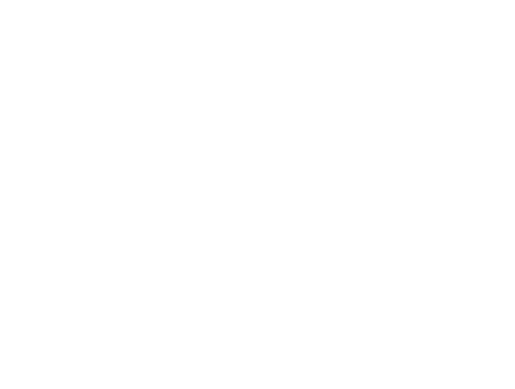

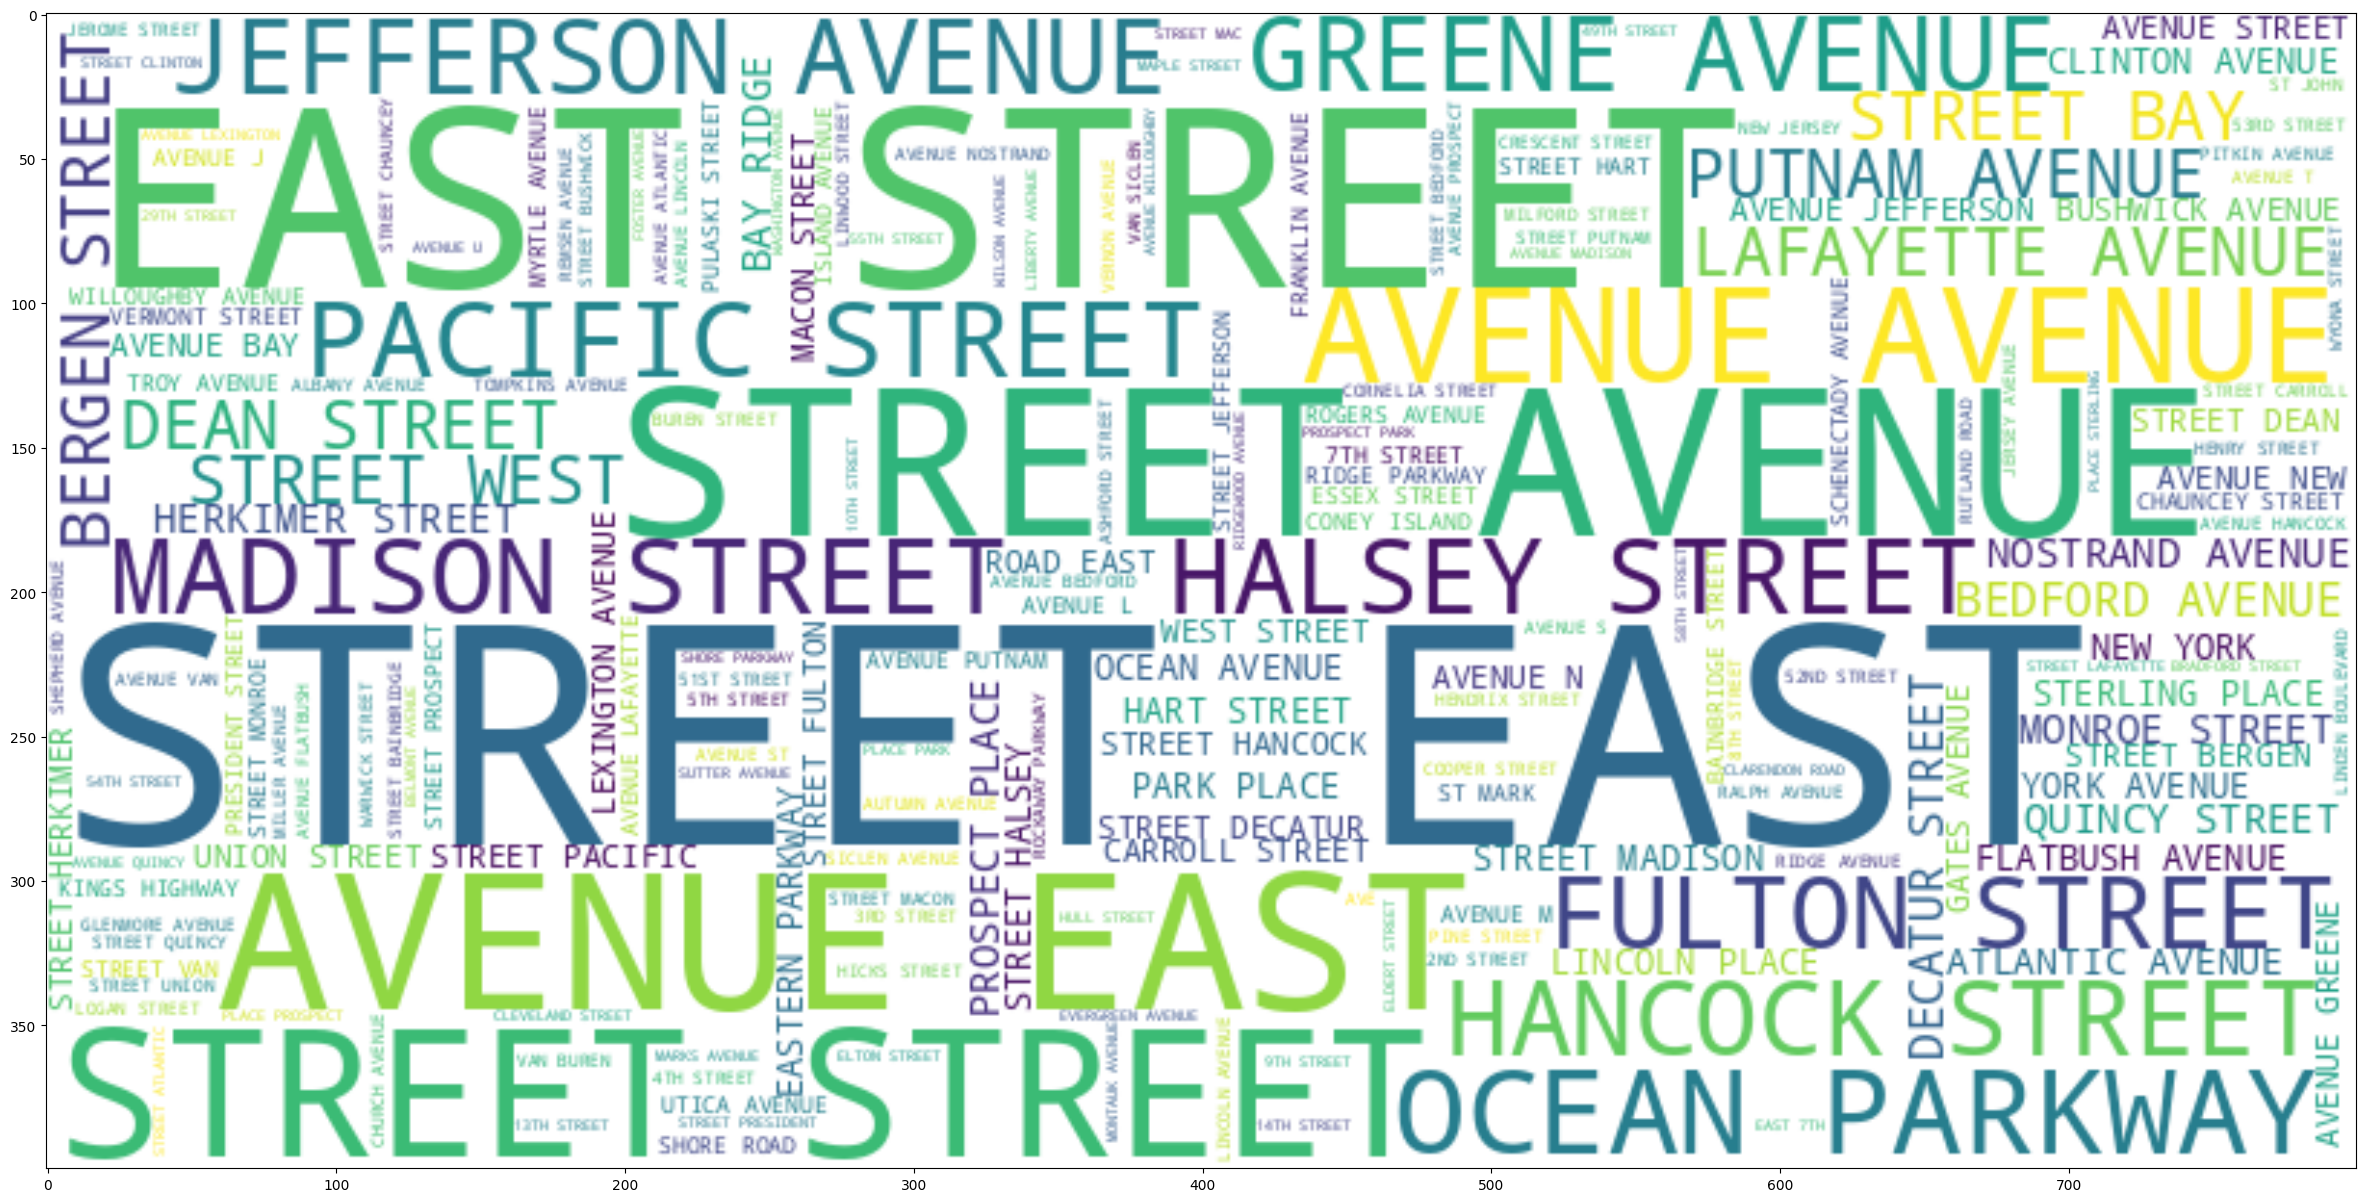

In [ ]:
text = " ".join(address for address in df[df.address.isin(repeated_address)].address)

# generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# display the word cloud
plt.axis("off")
plt.figure(figsize=(30,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

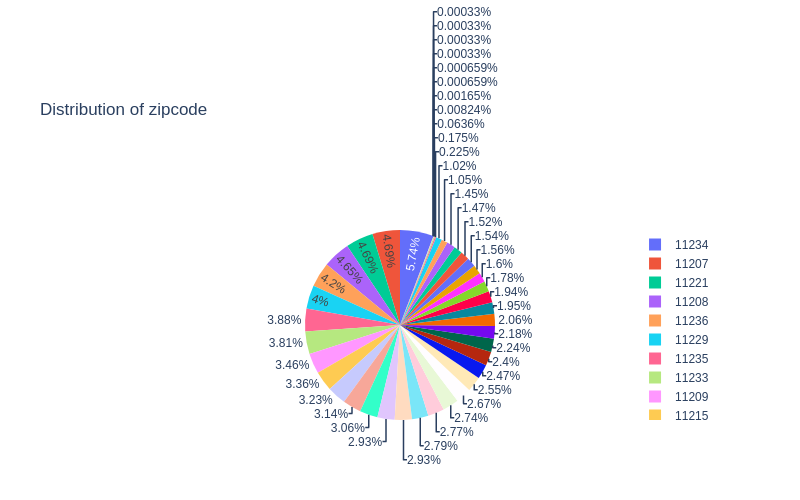

In [ ]:
plotly_plot_pie(df, column='zip_code', title='Distribution of zipcode', width=800)

From this word cloud and pie chart we can say it is too complicated if we want to use thess informations to interpret the data, for the case of address we see there are so many duplicate address which can be due to the repeating transaction over the same property, we still keep this features because it is still worth to be consider when it comes to the price estimation.For another case, later we will just take the last 2 digits to categorize them in a more efficient way.

# search for outliers

In [ ]:
df["sale_price"].value_counts(normalize=True).round(2)
#Viewing the value counts, we can see that 36% of the properties have no sales price data. We will drop all properties without this data.

0.0         0.36
10.0        0.01
450000.0    0.01
600000.0    0.01
400000.0    0.01
            ... 
462214.0    0.00
462205.0    0.00
462201.0    0.00
462161.0    0.00
316893.0    0.00
Name: sale_price, Length: 18219, dtype: float64

In [ ]:
df["sale_price"].quantile([0, 0.21, 0.5, 0.68, 0.90, 0.997, 1])
#Looking at the distribution of data, we can see an extensive range of price data.

0.000            0.0
0.210            0.0
0.500       250000.0
0.680       483000.0
0.900       950000.0
0.997     11000000.0
1.000    345000000.0
Name: sale_price, dtype: float64

We can use graphing to search for outliers in the sales_price column.

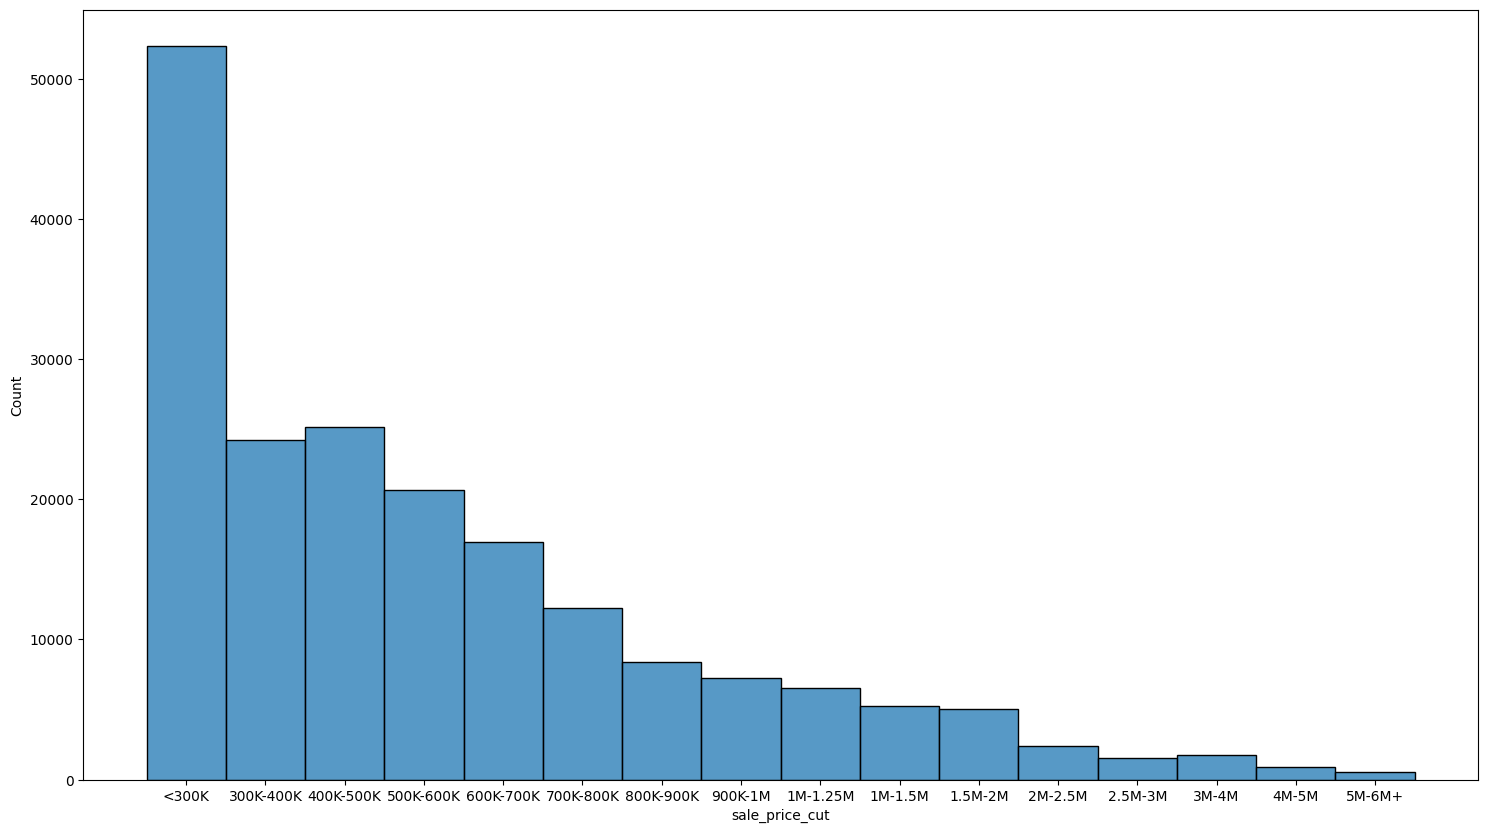

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10)) #Creating a larger figure to display the sale_price graph to make it easier to read.
cut_labels_16 = ["<300K", "300K-400K", "400K-500K", "500K-600K", "600K-700K", "700K-800K", "800K-900K", "900K-1M", "1M-1.25M", "1M-1.5M", "1.5M-2M", "2M-2.5M", "2.5M-3M", "3M-4M", "4M-5M", "5M-6M+"] #Creating labels for the new column.
cut_bins = [0, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1250000, 1500000, 2000000, 2500000, 3000000, 4000000, 5000000, 6000000] #Bins are based on Zillow's price points.
df["sale_price_cut"] = pd.cut(df["sale_price"], bins=cut_bins, labels=cut_labels_16) #Creating a new column cut from the previous sales column.
sns.histplot(x=df["sale_price_cut"], ax=ax) #Countplot should be much easier to read now.
df.drop('sale_price_cut', axis=1, inplace=True) #We drop the column that we created after we use it to graph the sale_price data.

We can see that zip codes in Brooklyn start at 11201 and end at 11256.

In [ ]:
#We can use the value_count() function to see how many properties have a zip code value less than 11201 and greater than 11256.

df[(df["zip_code"] < 11201) | (df["zip_code"] > 11256)]["zip_code"].value_counts()

0        193
11416     25
33803      2
11200      1
11258      1
Name: zip_code, dtype: int64

We can map how many times a property with each zip code appears in the data set using Seaborn's countplot() function.

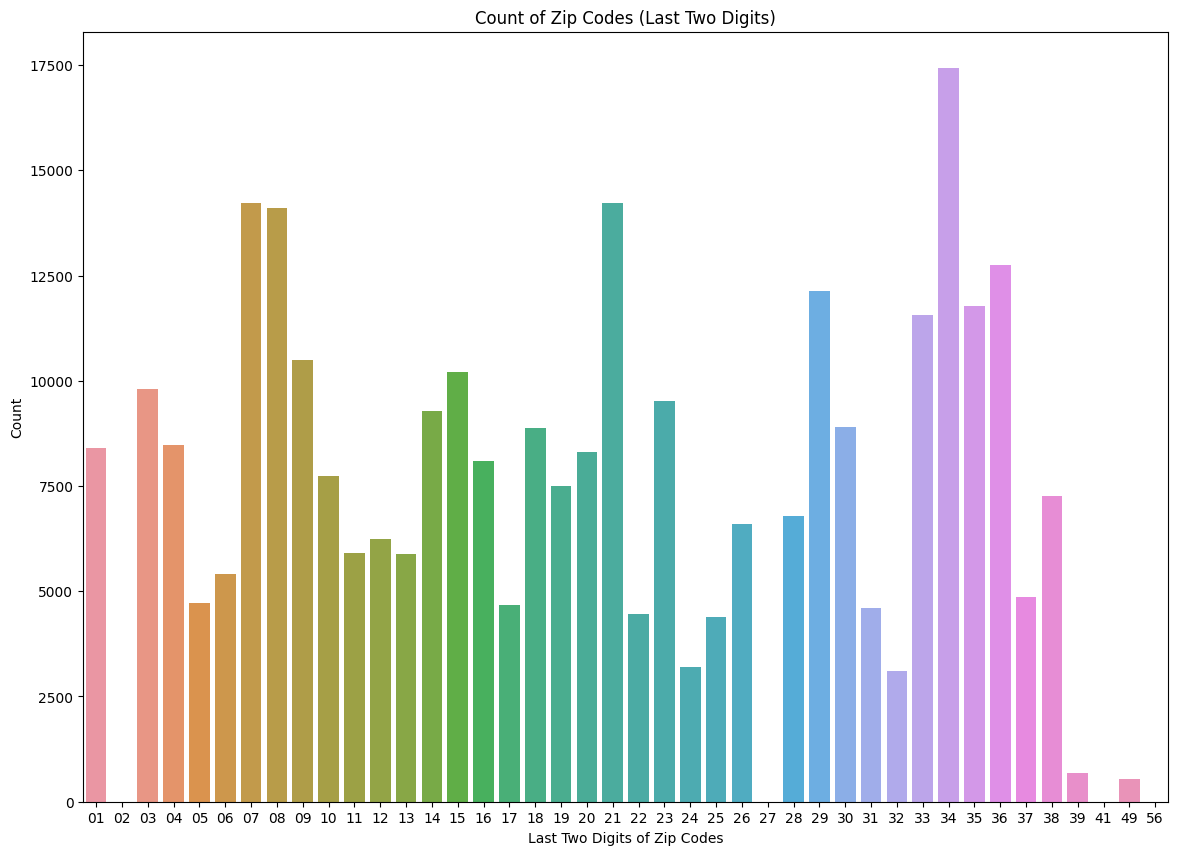

In [ ]:
#Let's try to map out how often each zip code actually appears in dataset.

#Removing all the zip codes that are out of range
df.drop(df.index[(df["zip_code"] < 11201) | (df["zip_code"] > 11256)], inplace=True)

# Extract the last two digits of zip codes
df["last_two_digits"] = df["zip_code"].astype(str).str[-2:]

# Get the sorted unique last two digits
sorted_last_two_digits = df["last_two_digits"].unique()
sorted_last_two_digits.sort()

# Set the size of the figure before creating the plot
plt.figure(figsize=(14, 10))

# Create the count plot with the x-axis arranged in order of last two digits
ax = sns.countplot(x="last_two_digits", data=df, order=sorted_last_two_digits)

# Add titles, labels, etc. if needed
plt.title('Count of Zip Codes (Last Two Digits)')
plt.xlabel('Last Two Digits of Zip Codes')
plt.ylabel('Count')

# Display the plot
plt.show()

This category is highly imbalanced, we can use TargetEncoder() with our machine learning model to encode the data so that our XGBoost model can interpret it.

In [ ]:
le = LabelEncoder() #Creating a label encoder to convert each zip code to an integer.
df["zip_code_encoder"] = le.fit_transform(df["zip_code"]) #Creating a new column with the newly encoded values.

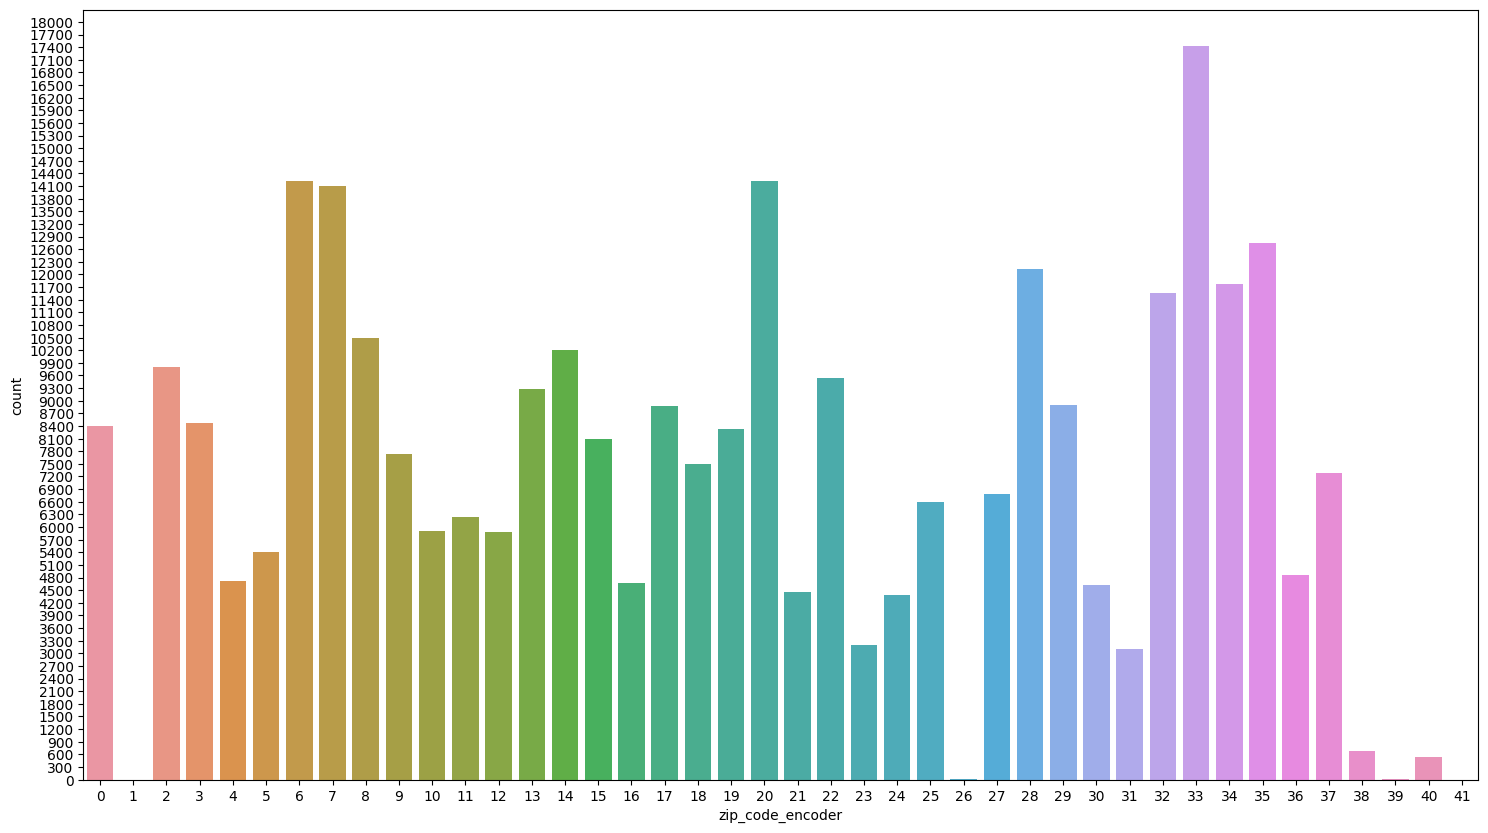

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10)) #Creating a larger figure to display the graph.
ax.set_yticks(np.arange(0, len(df["zip_code"]), 300)) #Changing the tick marks because they're a bit too high by default.
sns.countplot(x=df["zip_code_encoder"], ax=ax) #Let's try to map out how often each zip code appears in our dataset.
df.drop('zip_code_encoder', axis=1, inplace=True)

This category is highly imbalanced, even considering the few invalid zip codes that will be dropped later.

We can use TargetEncoder() with our machine learning model to encode the data so that our XGBoost model can interpret it.

**Searching for Outliers: Building Classes**

Each piece of NYC real estate has a building code that dictates what type of real estate it is. Building codes are used for tax and appraisal purposes.

NYC is complicated because people sometimes live in mixed-use real estate.

We can remove further building classes from our dataset by removing classes that are not residential real estate.

NYC publishes a full-list of building codes here. Using their list, we can see that building codes E,F,G,H,I,J,M,M,O,P,Q,T,U,W,Y and Z do not represent residential or mixed-use buildings and instead represent warehouses, factories, government buildings, etc.

We can use Seaborn's countplot() to graph what building classes are in the dataset to find out what we can do to remove outliers further.

In [ ]:
def wrangle(df):
    #Dropping properties that are below the 99.7% percentile or the first .21% of the data.
    df.drop(df.index[df["year_built"] < 1910], inplace=True)
    #Droppping all properties less than 644 sqft and greater than 49,400 sqft.
    df.drop(df.index[(df["land_sqft"] < 644) | (df["land_sqft"] > 49400)], inplace=True)
    #Dropping all properties with lots greater than 32,125 square feet.
    df.drop(df.index[df["LotArea"] > 32125.0], inplace=True)
    #Dropping all properties without sale_price data.
    df.drop(df.index[df["sale_price"] == 0], inplace=True)
    #Dropping sale_price outliers based on our graphing.
    df.drop(df.index[(df["sale_price"] < 333000) | (df["sale_price"] > 5000000)], inplace=True)
    #Removing all the zip codes that are out of range
    df.drop(df.index[(df["zip_code"] < 11201) | (df["zip_code"] > 11256)], inplace=True)
    #The value counts are saved in their own Series variable.
    counts = df['building_class_at_sale'].value_counts()
    #We drop all building classes with less than 100 values.
    df.drop(df.index[df['building_class_at_sale'].isin(counts[counts < 100].index)], inplace=True)
    #Drop all building classes that start with a letter from the list.
    df.drop(df.index[df['building_class_at_sale'].str.startswith(('E','F','G','H','I','J','M','N','O','P','Q','T','U','W','Y','Z'))], inplace=True)

In [ ]:
wrangle(df) #Calling the data wrangling function we created and passing in the DataFrame.

<Axes: xlabel='building_class_at_sale', ylabel='count'>

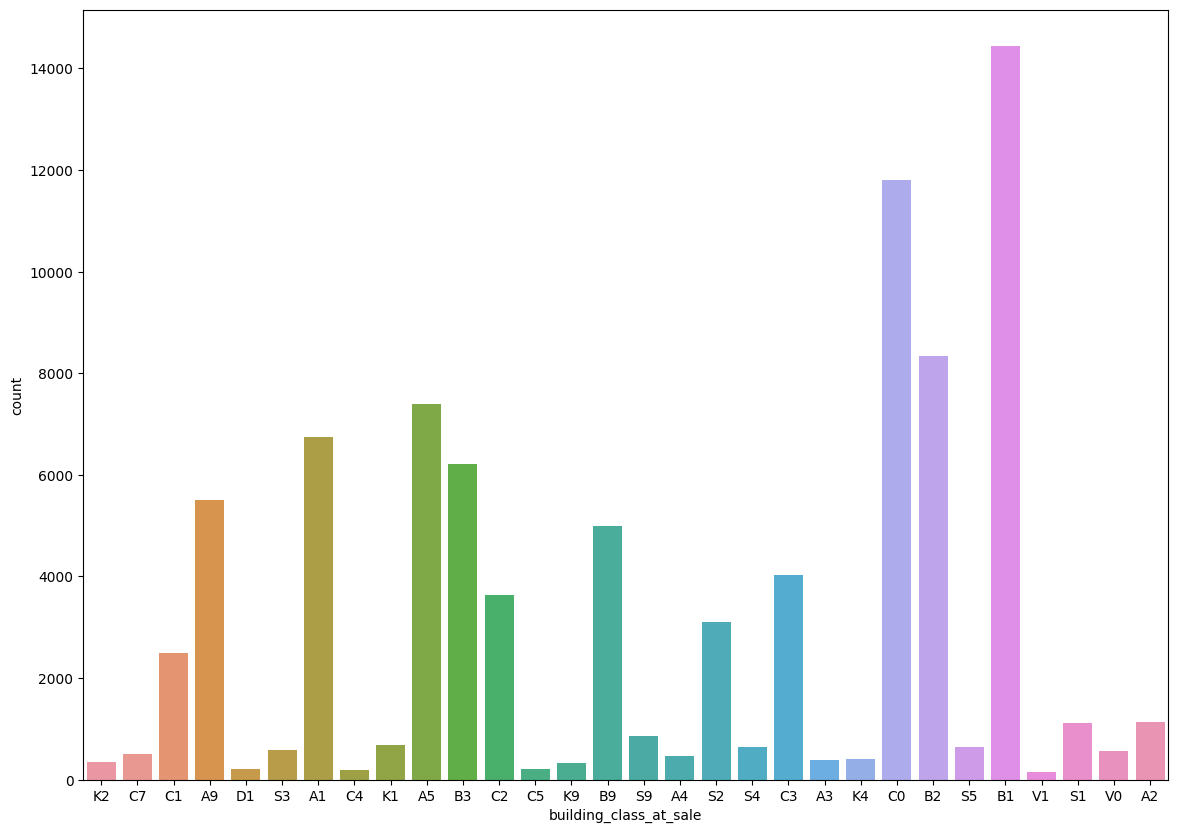

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.countplot(x=df["building_class_at_sale"], ax=ax) #Mapping out how many time each building class appears in the data set.

In [ ]:
!pip install category_encoders

from category_encoders import TargetEncoder
from xgboost import XGBRegressor

#Function to create the machine learning model
def create_model(df):
    #X includes every column except the sale_price column because that's what we're trying to predict.
    X = df.drop('sale_price', axis=1).copy()
    #y represents the column we're trying to predict, the sale price for each property.
    y = df[['sale_price']].copy()
    #We pass in X and y into the train_test_split() function.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    preprocessor = ColumnTransformer(
        transformers=[
            #Target encoding is used on all the categorical features in X: zip_code, year_built,
            # building_class_at_sale, SchoolDist, LotArea, ProxCode, sale_year, sale_month, and sale_day.
            ('target_encoded', TargetEncoder(), [2,4,5,6,8,9,10,11]),
            #We use RobustScaler for both the continious variable features: land_sqft and LotArea.
            ('numeric', RobustScaler(), [3,7])
        ],
        #All other columns are dropped from the model.
        remainder='drop')
    #We use XGBRegressor with the reg:squarederror objective, because we want to create a linear regression model powered by XGBoost.
    xgb_model = XGBRegressor(objective='reg:squarederror')

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb_model)
    ])
    #Training our model using the X_train and y_train data.
    pipeline.fit(X_train, y_train)
    #We return the pipeline, X_test, and y_test objects.
    return pipeline, X_test, y_test

In [ ]:
#We call the create_model function and pass the returned objects into the pipeline, X_test, and y_test variables.
pipeline, X_test, y_test = create_model(df)

In [ ]:
#y_pred saves the predicted output from the model given or test data input.
y_pred = pipeline.predict(X_test)

# Principal Component Analysis

In [ ]:
df.head()

,address,apartment_number,zip_code,land_sqft,year_built,building_class_at_sale,sale_price,SchoolDist,LotArea,ProxCode,sale_year,sale_month,sale_day,last_two_digits
2455,1756 86TH STREET,NaN,11214,9666,1920,K2,5000000.0,20,9666.0,2,2010,7,1,14
2456,801 70 STREET,50,11228,15000,1926,C7,5000000.0,20,15000.0,0,2010,6,24,28
2462,1580 PRESIDENT STREET,NaN,11213,8800,1916,C1,5000000.0,17,8800.0,0,2011,4,4,13
2465,14 COLLEGE PLACE,NaN,11201,2050,1920,A9,5000000.0,13,2050.0,3,2012,12,31,01
2468,305 EAST 34TH STREET,42,11203,10000,1936,D1,5000000.0,17,10000.0,2,2012,4,24,03


In [ ]:
from sklearn.decomposition import PCA

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

features = [
    "land_sqft",
    "year_built",
    "LotArea",
    "sale_year",
]


X_upca = df.copy()
y = X_upca.pop("sale_price")
X = X_upca.loc[:, features]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                 PC1       PC2       PC3       PC4
land_sqft   0.706769 -0.021186 -0.004536 -0.707112
year_built  0.026610  0.704798  0.708908  0.000932
LotArea     0.706758 -0.021583 -0.006001  0.707101
sale_year  -0.016188 -0.708763  0.705261  0.000532


In [ ]:
X_pca.melt()

,variable,value
0,PC1,7.119574
1,PC1,12.455306
2,PC1,6.246696
3,PC1,-0.497416
4,PC1,7.462252
...,...,...
352259,PC4,-0.002136
352260,PC4,-0.001733
352261,PC4,-0.001296
352262,PC4,-0.002136


In [162]:
from sklearn.model_selection import cross_val_score
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)

    return score



X = df.copy()

filtered_data = X.dropna(subset=['land_sqft', 'year_built', 'LotArea', 'sale_year'])

y = filtered_data.pop("sale_price")

X["Feature1"] = X.land_sqft + X.LotArea
X["Feature2"] = X.year_built * X.LotArea

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.04160 RMSLE


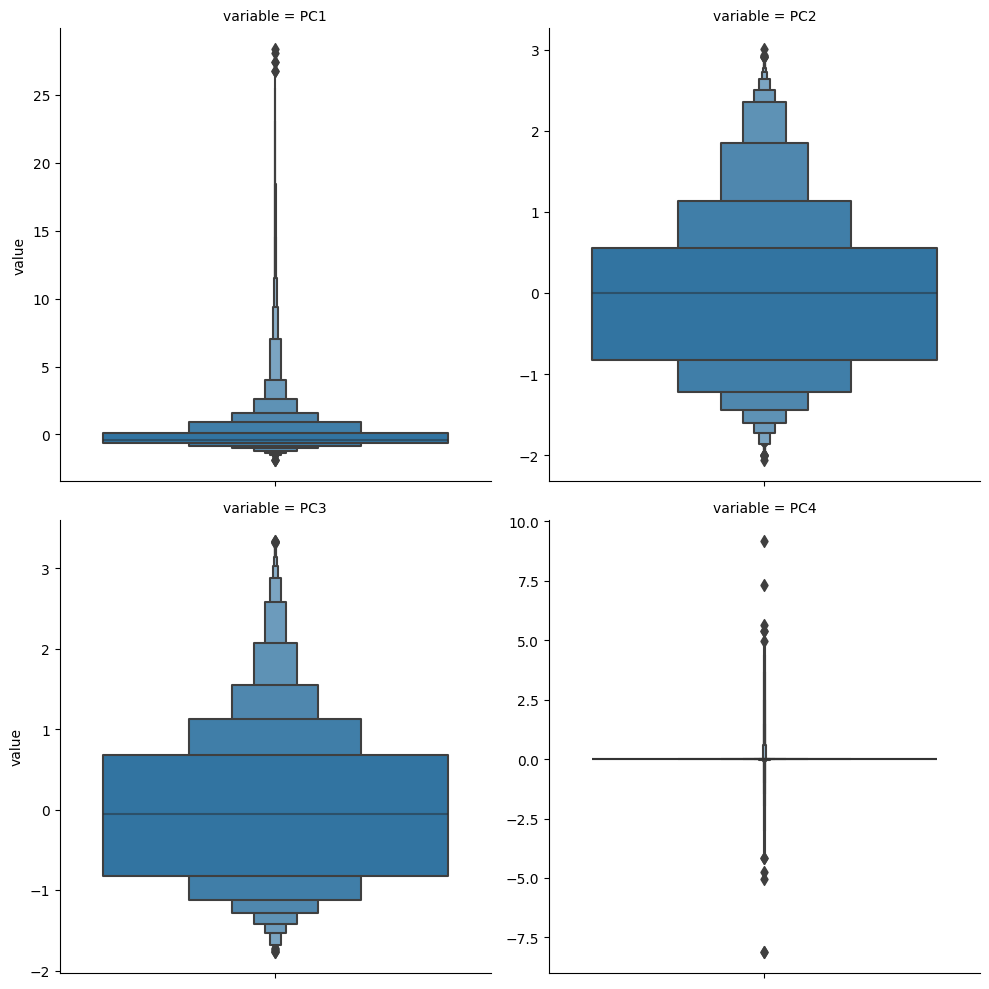

In [163]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [167]:
cor_mat1 = np.corrcoef(X_pca.T)
eig_vals, eig_vecs = np.linalg.eig(cor_mat1)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 1.          0.05164579  0.24399859 -0.0109919 ]
 [ 0.          0.76852028 -0.33332109  0.39698165]
 [ 0.          0.55524453  0.17761343 -0.83290776]
 [ 0.          0.31370814  0.89320502  0.38542108]]

Eigenvalues 
[1. 1. 1. 1.]


We can observed that there are a few outliers in PC1 located above the value of 25, and PC1 is not correlated much to other PCA components which means it has independent clues and more informations than others since it is the first component. since PCA is gathering the most important information for the factor that affect the sale price, they can help us to save a lot of times when we do the regression or other machine learning models.

For other parts we will put them into the Assignment 4 for more explanation and experiment for refreesion